#  Libraries

In [1]:
import pandas as pd
#import functions as f
#import holidays as h
import os
import pickle
import time
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from string import punctuation
import pandas as pd
import numpy as np
from itertools import product
import datetime

In [81]:
import xgboost as xgb
import time
import warnings

import pickle
from xgboost import plot_importance
warnings.filterwarnings('ignore')

# Functions

## Item Category

In [199]:
def correct_item_category_name(df):
    'adjust the format of the "item_category_name" column'
    df.loc[df['item_category_name'] == 'Билеты (Цифра)','item_category_name'] = 'Билеты - Цифра'
    df.loc[df['item_category_name'] == 'Доставка товара','item_category_name'] = 'Доставка товара - service'
    df.loc[df['item_category_name'] == 'Карты оплаты (Кино, Музыка, Игры)',
           'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
    df.loc[df['item_category_name'] == 'Служебные','item_category_name'] = 'Служебные - none'
    df.loc[df['item_category_name'] == 'Чистые носители (шпиль)','item_category_name'] = 'Чистые носители - шпиль'
    df.loc[df['item_category_name'] == 'Чистые носители (штучные)','item_category_name'] = 'Чистые носители - штучные'
    df.loc[df['item_category_name'] == 'Элементы питания','item_category_name'] = 'Элементы питания - none'
    
    return df


def extract_main_category(df):
    df['item_category_main'] = df['item_category_name'].str.split(' - ').str[0]

    le = preprocessing.LabelEncoder()
    df['item_category_main'] = le.fit_transform(df['item_category_main'])

    return df

def extract_whether_digital(df):
    df['is_category_digital'] = 0
    df.loc[df['item_category_name'].str.contains('Цифра'),'is_category_digital'] = 1
    
    return df

def extract_ps_related(df):
    df['is_category_ps_related'] = 0
    df.loc[df['item_category_name'].str.contains('PS'),'is_category_ps_related'] = 1
    
    return df

def fix_item_category(df):
    df = correct_item_category_name(df)
    df = extract_main_category(df)
    df = extract_whether_digital(df)
    df = extract_ps_related(df)
    df.drop(columns = ['item_category_name'], inplace = True)
    
    return df

## Sales

In [200]:
def prepare_sales_montly(sales):
    
    sales_train_df_no_dupl_shops = adjust_duplicated_shops(sales)
    
    sales_train_montly_df = sales_train_df_no_dupl_shops.groupby(
        ['date_block_num','shop_id','item_id'])['item_price','item_cnt_day','date'].agg(
                        {'item_price':'mean',
                        'date':'min',
                        'item_cnt_day':'sum'})
    sales_train_montly_df = sales_train_montly_df.reset_index()

    colnames = ['date_block_num', 'shop_id', 'item_id', 'item_price_avg','date_min','item_cnt_month']
    sales_train_montly_df.columns = colnames
    
    return sales_train_montly_df



def remove_outliers(df):
    return df[(df["item_price"] < np.percentile(df["item_price"], q=99))
              & (df["item_price"] > 0)
              & (df["item_cnt_day"] >= 0)
              & (df["item_cnt_day"] < np.percentile(df["item_cnt_day"], q=99))]


def adjust_duplicated_shops(df):
    'Function that combines duplicated shop names'
    # from https://www.kaggle.com/taranenkodaria/predict-future-sales-the-russian-forecast
    # Test Set unique shop_id --> we should only use these ids
    # array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
    #   26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
    #   50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)
    
    df.loc[df['shop_id'] == 0, 'shop_id'] = 57
    df.loc[df['shop_id'] == 1, 'shop_id'] = 58
    df.loc[df['shop_id'] == 11, 'shop_id'] = 10
    df.loc[df['shop_id'] == 40, 'shop_id'] = 39
    df.loc[df['shop_id'] == 23, 'shop_id'] = 24
    
    return df

## shops

In [201]:
def extract_shop_type(df):
    'Extracts type of the shop and creates the shop_type_1 and shop_type_2 columns'
    
    df['shop_type_1'] = 'NONE'
    df['shop_type_2'] = 'NONE'
    
    df.loc[df['shop_name'].str.contains('ТЦ'),'shop_type_1'] = 'type_1'
    df.loc[df['shop_name'].str.contains('ТК'),'shop_type_1'] = 'type_2'
    df.loc[df['shop_name'].str.contains('ТРЦ'),'shop_type_1'] = 'type_3'
    df.loc[df['shop_name'].str.contains('ТРК'),'shop_type_1'] = 'type_4' 
    
    df.loc[(df['shop_name'].str.contains('ТЦ')) |
           (df['shop_name'].str.contains('ТК')),'shop_type_2'] = 'type_1'
    df.loc[(df['shop_name'].str.contains('ТРЦ')) |
           (df['shop_name'].str.contains('ТРК')),'shop_type_2'] = 'type_2'
    
    le_1 = preprocessing.LabelEncoder()
    df['shop_type_1'] = le_1.fit_transform(df['shop_type_1'])
    le_2 = preprocessing.LabelEncoder()
    df['shop_type_2'] = le_2.fit_transform(df['shop_type_2'])
    
    return df

def extract_shop_city(df):
    'Extracts shop city name and city type and creates two new columns'
    
    # City type: 1 if city is Moscow or Sankt Petersburg (they are quite different from the rest of Russia)
    df['shop_city_type'] = 0
    
    df['shop_city'] = df['shop_name'].str.split(' ').str[0]
    df.loc[df['shop_city'].isin(['Москва','СПб']),'shop_city_type'] = 1
    
    le = preprocessing.LabelEncoder()
    df['shop_city'] = le.fit_transform(df['shop_city'])
    
    return df


def fix_shops(shops_df):
    """
    This function modifies the shops df inplace.
    It correct's 3 shops that we have found to be 'duplicates'
    and also creates a few more features: extracts the city and encodes it using LabelEncoder
    """
    
    shops_df = shops_df.loc[~shops_df['shop_id'].isin([0, 1, 11, 40, 23])]
    shops_df = extract_shop_type(shops_df)
    shops_df = extract_shop_city(shops_df)
    shops_df.drop(columns = ['shop_name'], inplace = True)

    return shops_df

## Matrix

In [202]:
def create_matrix(df):
    x = datetime.date(2013, 1, 1)
    matrix = []
    cols = ["date_block_num", "shop_id", "item_id", "Year", "Month"]
    for i in range(34):
        try:
            sales = df[df.date_block_num == i]
            matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique(), [x.year], [x.month])), dtype=np.int16))
            x = x.replace(month=x.month+1)
        except ValueError:
            if x.month == 12:
                x = x.replace(year=x.year+1, month=1)
            else:
                # next month is too short to have "same date"
                # pick your own heuristic, or re-raise the exception:
                raise

    matrix = pd.DataFrame(np.vstack(matrix), columns = cols )
    matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
    matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
    matrix["item_id"] = matrix["item_id"].astype(np.int16)
    matrix.sort_values(cols, inplace=True)

    return matrix


def add_zero_sales(df, matrix):
    if matrix is None:
        matrix = create_matrix(df)
    #df.drop(columns = ['date_min'], inplace = True)
    df = pd.merge(matrix, df, how='left',
                  left_on=['date_block_num', 'shop_id', 'item_id'],
                  right_on=['date_block_num', 'shop_id', 'item_id'])

    return df

## Russian Hollidays

In [203]:
russian_holidays_start = [
    datetime.date(2013, 1, 1),
    datetime.date(2013, 2, 23),
    datetime.date(2013, 3, 8),
    datetime.date(2013, 5, 1),
    datetime.date(2013, 5, 9),
    datetime.date(2013, 6, 12),
    datetime.date(2013, 11, 4),

    datetime.date(2014, 1, 1),
    datetime.date(2014, 2, 23),
    datetime.date(2014, 3, 8),
    datetime.date(2014, 5, 1),
    datetime.date(2014, 5, 9),
    datetime.date(2014, 6, 12),
    datetime.date(2014, 11, 4),

    datetime.date(2015, 1, 1),
    datetime.date(2015, 2, 23),
    datetime.date(2015, 3, 8),
    datetime.date(2015, 5, 1),
    datetime.date(2015, 5, 9),
    datetime.date(2015, 6, 12),
    datetime.date(2015, 11, 4)
]

russian_holidays_end = [
    datetime.date(2013, 1, 8),
    datetime.date(2013, 2, 23),
    datetime.date(2013, 3, 8),
    datetime.date(2013, 5, 1),
    datetime.date(2013, 5, 9),
    datetime.date(2013, 6, 12),
    datetime.date(2013, 11, 4),

    datetime.date(2014, 1, 8),
    datetime.date(2014, 2, 23),
    datetime.date(2014, 3, 8),
    datetime.date(2014, 5, 1),
    datetime.date(2014, 5, 9),
    datetime.date(2014, 6, 12),
    datetime.date(2014, 11, 4),

    datetime.date(2015, 1, 8),
    datetime.date(2015, 2, 23),
    datetime.date(2015, 3, 8),
    datetime.date(2015, 5, 1),
    datetime.date(2015, 5, 9),
    datetime.date(2015, 6, 12),
    datetime.date(2015, 11, 4)
]


def russian_holidays():
    holidays = pd.DataFrame(columns=['Year', 'Month', 'holidays'])

    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        holidays = holidays.append(
            {'Year': start_date.year, 'Month': start_date.month, 'holidays': (end_date - start_date).days + 1},
            ignore_index=True)
    holidays['Year'] = holidays['Year'].astype('int64')
    holidays['Month'] = holidays['Month'].astype('int64')
    return holidays


def add_holidays(final_df):
    final_df = pd.merge(final_df, russian_holidays(),  how='left', left_on=['Year', 'Month'], right_on=['Year', 'Month'])
    return final_df.drop_duplicates()

## Train DF

In [208]:
def prepare_sales():
    # load and preprocess sales
    sales = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
    sales = remove_outliers(sales)
    sales = prepare_sales_montly(sales)
    # matrix 
    matrix = create_matrix(sales)
    sales_transformed = add_zero_sales(sales, matrix)
    
    return sales_transformed

def create_train_df(sales):
    """
    This is a helper function that creates the train df.
    """
    # load shops and preprocess it
    shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
    shops = fix_shops(shops)  # fix the shops as we have seen before
    
    # load item_category and preprocess it
    items_category = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
    items_category = fix_item_category(items_category)
    
    # load items
    items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
    items.drop(columns = ['item_name'], inplace = True)
    
    # merge data
    items_to_merge = items.merge(items_category, on = 'item_category_id')
    merged_df = sales.merge(shops, on = 'shop_id', how = 'left')
    merged_df = merged_df.merge(items_to_merge, on = 'item_id', how = 'left')
    merged_df = add_previous_months_sales(merged_df)
    
    merged_df = remove_nan(merged_df)
    #merged_df = calculate_missing_prices_for_train_set(merged_df)
    
    #merged_df = downcast_dtypes(merged_df)
    
    return merged_df


def add_previous_months_sales(origin_df, list_lags=None):
    if list_lags is None:
        list_lags = [1, 2, 3]

    final_df = origin_df.copy()

    for month_shift in list_lags:
        shifted = origin_df.copy()
        shifted = shifted[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
        shifted.date_block_num = shifted.date_block_num + month_shift
        shifted.rename(columns={"item_cnt_month": "item_cnt_month_"+str(month_shift)}, inplace=True)
        final_df = pd.merge(final_df, shifted,  how='left', left_on=['date_block_num', 'shop_id', 'item_id'],
                            right_on=['date_block_num', 'shop_id', 'item_id'])
    del shifted

    return final_df.drop_duplicates()


def remove_nan(df):
    df['item_cnt_month'] = df['item_cnt_month'].fillna(0)
    df['item_cnt_month_1'] = df['item_cnt_month_1'].fillna(0)
    df['item_cnt_month_2'] = df['item_cnt_month_2'].fillna(0)
    df['item_cnt_month_3'] = df['item_cnt_month_3'].fillna(0)
    #df['holidays'] = df['holidays'].fillna(0)
    df.drop(columns = ['date_min'], inplace = True)
    
    return df

def downcast_dtypes(df):
    """
        Changes column types in the dataframe:

                `float64` type to `float32`
                `int64`   type to `int32`
    """

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)

    return df

def calculate_missing_prices_for_train_set(df):
    average_price = df.sort_values(['date_block_num']).dropna(subset = ['item_price_avg'])
    average_price = average_price.drop_duplicates(subset = ['item_id'], keep = 'last')[['item_id','item_price_avg']]


    train_df_is_null = df.loc[df['item_price_avg'].isnull()]
    train_df_is_null.drop(columns = ['item_price_avg'], inplace = True)
    train_df_is_null = train_df_is_null.merge(average_price, on = 'item_id', how = 'left')

    train_df_is_not_null = df.loc[~train_df['item_price_avg'].isnull()]

    train_df_final = pd.concat([train_df_is_null, train_df_is_not_null], axis = 0)
    
    return train_df_final

In [205]:
sales = prepare_sales()

In [220]:
train_df = create_train_df(sales)
train_df = calculate_missing_prices_for_train_set(train_df)
train_df = downcast_dtypes(train_df)

In [221]:
train_df.shape

(10685502, 18)

In [223]:
train_df.isnull().mean()

date_block_num            0.0
shop_id                   0.0
item_id                   0.0
Year                      0.0
Month                     0.0
item_cnt_month            0.0
shop_type_1               0.0
shop_type_2               0.0
shop_city_type            0.0
shop_city                 0.0
item_category_id          0.0
item_category_main        0.0
is_category_digital       0.0
is_category_ps_related    0.0
item_cnt_month_1          0.0
item_cnt_month_2          0.0
item_cnt_month_3          0.0
item_price_avg            0.0
dtype: float64

In [222]:
train_df

,date_block_num,shop_id,item_id,Year,Month,item_cnt_month,shop_type_1,shop_type_2,shop_city_type,shop_city,item_category_id,item_category_main,is_category_digital,is_category_ps_related,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_price_avg
0,0,2,19,2013,1,0.0,1,1,0,0,40,10,0,0,0.0,0.0,0.0,28.0
1,0,2,28,2013,1,0.0,1,1,0,0,30,8,0,0,0.0,0.0,0.0,199.0
2,0,2,29,2013,1,0.0,1,1,0,0,23,5,0,0,0.0,0.0,0.0,1198.0
3,0,2,32,2013,1,0.0,1,1,0,0,40,10,0,0,0.0,0.0,0.0,149.0
4,0,2,34,2013,1,0.0,1,1,0,0,40,10,0,0,0.0,0.0,0.0,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685481,33,59,22087,2015,10,6.0,1,1,0,30,83,17,0,0,3.0,2.0,5.0,119.0
10685482,33,59,22088,2015,10,2.0,1,1,0,30,83,17,0,0,1.0,7.0,7.0,119.0
10685483,33,59,22091,2015,10,1.0,1,1,0,30,83,17,0,0,3.0,0.0,0.0,179.0
10685485,33,59,22100,2015,10,1.0,1,1,0,30,42,11,0,0,1.0,0.0,0.0,629.0


In [197]:
train_df.shape

(10685502, 18)

In [198]:
train_df_copy = train_df.copy()

# Train DF

In [225]:
train_df

,date_block_num,shop_id,item_id,Year,Month,item_cnt_month,shop_type_1,shop_type_2,shop_city_type,shop_city,item_category_id,item_category_main,is_category_digital,is_category_ps_related,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_price_avg
0,0,2,19,2013,1,0.0,1,1,0,0,40,10,0,0,0.0,0.0,0.0,28.0
1,0,2,28,2013,1,0.0,1,1,0,0,30,8,0,0,0.0,0.0,0.0,199.0
2,0,2,29,2013,1,0.0,1,1,0,0,23,5,0,0,0.0,0.0,0.0,1198.0
3,0,2,32,2013,1,0.0,1,1,0,0,40,10,0,0,0.0,0.0,0.0,149.0
4,0,2,34,2013,1,0.0,1,1,0,0,40,10,0,0,0.0,0.0,0.0,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685481,33,59,22087,2015,10,6.0,1,1,0,30,83,17,0,0,3.0,2.0,5.0,119.0
10685482,33,59,22088,2015,10,2.0,1,1,0,30,83,17,0,0,1.0,7.0,7.0,119.0
10685483,33,59,22091,2015,10,1.0,1,1,0,30,83,17,0,0,3.0,0.0,0.0,179.0
10685485,33,59,22100,2015,10,1.0,1,1,0,30,42,11,0,0,1.0,0.0,0.0,629.0


In [226]:
features = ['date_block_num', 'shop_id', 'item_id', 'Year', 'Month', 'shop_type_1',
       'shop_type_2', 'shop_city_type', 'shop_city', 'item_category_id',
       'item_category_main', 'is_category_digital', 'is_category_ps_related',
       'item_cnt_month_1', 'item_cnt_month_2', 'item_cnt_month_3',
       'item_price_avg']

target = ['item_cnt_month']

train = train_df[(train_df["date_block_num"] < 32)]
val = train_df[(train_df["date_block_num"] >= 32)]
X_train = train.drop(columns = target)
X_train = X_train.loc[:,features]
X_val = val.drop(columns = target)
X_val = X_val.loc[:,features]

Y_train = train[target]
Y_val = val[target]

X_train['Year'] = X_train['Year'].astype(int)
X_train['Month'] = X_train['Month'].astype(int)
#X_train['holidays'] = X_train['holidays'].fillna(0)
#X_train['holidays'] = X_train['holidays'].astype(int)
X_val['Year'] = X_val['Year'].astype(int)
X_val['Month'] = X_val['Month'].astype(int)
#X_test['holidays'] = X_test['holidays'].fillna(0)
#X_test['holidays'] = X_test['holidays'].astype(int)

In [ ]:
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=True,
    early_stopping_rounds=None)

time.time() - ts

[0]	validation_0-rmse:1.27532	validation_1-rmse:1.14769
[1]	validation_0-rmse:1.23215	validation_1-rmse:1.10516
[2]	validation_0-rmse:1.19548	validation_1-rmse:1.06847
[3]	validation_0-rmse:1.16497	validation_1-rmse:1.03700
[4]	validation_0-rmse:1.13902	validation_1-rmse:1.01092
[5]	validation_0-rmse:1.11825	validation_1-rmse:0.98914
[6]	validation_0-rmse:1.10062	validation_1-rmse:0.97052
[7]	validation_0-rmse:1.08599	validation_1-rmse:0.95530
[8]	validation_0-rmse:1.07348	validation_1-rmse:0.94210
[9]	validation_0-rmse:1.06462	validation_1-rmse:0.93218
[10]	validation_0-rmse:1.05537	validation_1-rmse:0.92204
[11]	validation_0-rmse:1.04700	validation_1-rmse:0.91297
[12]	validation_0-rmse:1.04014	validation_1-rmse:0.90666
[13]	validation_0-rmse:1.03455	validation_1-rmse:0.90053
[14]	validation_0-rmse:1.02982	validation_1-rmse:0.89579
[15]	validation_0-rmse:1.02560	validation_1-rmse:0.89178
[16]	validation_0-rmse:1.02199	validation_1-rmse:0.88786
[17]	validation_0-rmse:1.01894	validation

[144]	validation_0-rmse:0.96205	validation_1-rmse:0.85828
[145]	validation_0-rmse:0.96127	validation_1-rmse:0.85849
[146]	validation_0-rmse:0.96063	validation_1-rmse:0.85865
[147]	validation_0-rmse:0.96027	validation_1-rmse:0.85837
[148]	validation_0-rmse:0.96010	validation_1-rmse:0.85800
[149]	validation_0-rmse:0.95992	validation_1-rmse:0.85810
[150]	validation_0-rmse:0.95986	validation_1-rmse:0.85811
[151]	validation_0-rmse:0.95977	validation_1-rmse:0.85807
[152]	validation_0-rmse:0.95950	validation_1-rmse:0.85799
[153]	validation_0-rmse:0.95935	validation_1-rmse:0.85792
[154]	validation_0-rmse:0.95923	validation_1-rmse:0.85741
[155]	validation_0-rmse:0.95909	validation_1-rmse:0.85737
[156]	validation_0-rmse:0.95864	validation_1-rmse:0.85767
[157]	validation_0-rmse:0.95841	validation_1-rmse:0.85747
[158]	validation_0-rmse:0.95823	validation_1-rmse:0.85727
[159]	validation_0-rmse:0.95811	validation_1-rmse:0.85708
[160]	validation_0-rmse:0.95801	validation_1-rmse:0.85703
[161]	validati

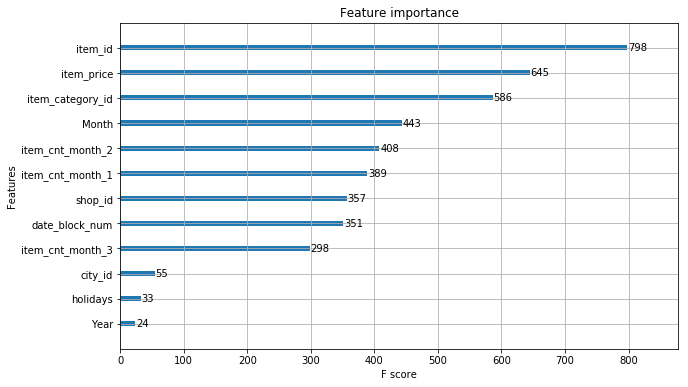

In [238]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,6))

# Test DF

In [212]:
def create_base_submission():
    shops = pd.read_csv("src/competitive-data-science-predict-future-sales/shops.csv")
    fix_shops(shops)
    items = pd.read_csv("src/competitive-data-science-predict-future-sales/items.csv")
    sales = pd.read_csv("src/competitive-data-science-predict-future-sales/sales_train.csv")
    test = pd.read_csv("src/competitive-data-science-predict-future-sales/test.csv")
    print('test size ', test.shape)

    items.drop(columns=['item_name'], inplace=True)
    shops.drop(columns=['shop_name_cleaned', 'city'], inplace=True)
    shops = shops.drop_duplicates()

    sales = remove_outliers(sales)
    sales.drop(columns=['item_cnt_day', 'date'], inplace=True)
    sales = sales.drop_duplicates()
    unique_sales = sales.groupby(['shop_id', 'item_id']).tail(1).reset_index()

    solution = pd.merge(test, unique_sales,  how='left', left_on=['shop_id', 'item_id'], right_on=['shop_id','item_id'])
    print('1 solution size ', solution.shape)

    solution = pd.merge(solution, shops,  how='left', left_on=['shop_id'], right_on=['shop_id'])
    print('2 solution size ', solution.shape)

    solution = pd.merge(solution, items,  how='left', left_on=['item_id'], right_on=['item_id'])
    print('3 solution size ', solution.shape)

    solution['date_block_num'] = 34
    solution['Year'] = 2015
    solution['Month'] = 11
    solution = solution.set_index('ID')
    solution.drop(columns=['index'], inplace=True)

    return solution

def add_lag(final_df):
    block33 = df[df['date_block_num'] == 33].copy()
    block33 = block33[['shop_id', 'item_id', 'item_cnt_month']]
    block33.rename(columns={"item_cnt_month": "item_cnt_month_1"}, inplace=True)
    final_df = pd.merge(final_df, block33,  how='left',
                         left_on = ['shop_id', 'item_id'],
                         right_on = ['shop_id', 'item_id'])
    final_df['item_cnt_month_1'] = final_df['item_cnt_month_1'].fillna(0)
    final_df = final_df.drop_duplicates()
    final_df = final_df.reset_index(drop=True)

    block32 = df[df['date_block_num'] == 32].copy()
    block32 = block32[['shop_id', 'item_id', 'item_cnt_month']]
    block32.rename(columns={"item_cnt_month": "item_cnt_month_2"}, inplace=True)
    final_df = pd.merge(final_df, block32,  how='left',
                        left_on = ['shop_id', 'item_id'],
                        right_on = ['shop_id', 'item_id'])
    final_df['item_cnt_month_2'] = final_df['item_cnt_month_2'].fillna(0)
    final_df = final_df.drop_duplicates()
    final_df = final_df.reset_index(drop=True)

    block31 = df[df['date_block_num'] == 31].copy()
    block31 = block31[['shop_id', 'item_id', 'item_cnt_month']]
    block31.rename(columns={"item_cnt_month": "item_cnt_month_3"}, inplace=True)
    final_df = pd.merge(final_df, block31,  how='left',
                        left_on = ['shop_id', 'item_id'],
                        right_on = ['shop_id', 'item_id'])
    final_df['item_cnt_month_3'] = final_df['item_cnt_month_3'].fillna(0)
    final_df = final_df.drop_duplicates()
    final_df = final_df.reset_index(drop=True)

    return final_df


In [216]:
final_df = create_base_submission()
print('df base size ', final_df.shape)

final_df = add_holidays(final_df)

final_df['Year'] = final_df['Year'].astype(int)
final_df['Month'] = final_df['Month'].astype(int)
final_df['holidays'] = final_df['holidays'].fillna(0)
final_df['holidays'] = final_df['holidays'].astype(int)
final_df['Year'] = final_df['Year'].astype(int)
final_df['Month'] = final_df['Month'].astype(int)
final_df['holidays'] = final_df['holidays'].fillna(0)
final_df['holidays'] = final_df['holidays'].astype(int)

print('df size with holiday ', final_df.shape)

final_df = add_lag(final_df)
final_df = downcast_dtypes(final_df)

test size  (214200, 3)
1 solution size  (214200, 6)
2 solution size  (214200, 7)
3 solution size  (214200, 8)
df base size  (214200, 8)
df size with holiday  (214200, 9)


In [217]:
y_pred = model.predict(final_df[['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_category_id', 'city_id',
                                 'Year', 'Month', 'holidays', 'item_cnt_month_1', 'item_cnt_month_2', 'item_cnt_month_3']])

final_df['item_cnt_month'] = y_pred.clip(0, 20)
final_df.drop(columns=['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_category_id', 'city_id', 'Year',
                       'Month', 'holidays',
                       'item_cnt_month_1', 'item_cnt_month_2', 'item_cnt_month_3'], inplace=True)

final_df = final_df.reset_index()
final_df.rename(columns={"index": "ID"}, inplace=True)

print('Expect (214200, 2)')
print('Actual ', final_df.shape)

timestr = time.strftime("%Y%m%d-%H%M%S")


Expect (214200, 2)
Actual  (214200, 2)


In [218]:
final_df

,ID,item_cnt_month
0,0,1.560834
1,1,1.955020
2,2,1.736403
3,3,1.218441
4,4,1.947394
5,5,1.372923
6,6,1.339642
7,7,1.312966
8,8,1.553770
9,9,1.947394


In [219]:
final_df.to_csv(timestr+'solution_xgboost.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
